In [1]:
import numpy as np
import scipy.integrate

The protocol optimizer allows you to find the most effective protocol for learning model parameters from noisy data. The user inputs a parametrized protocol and a method for simulating time series data from the model, and the code will attempt to find parameters for the protocol under which the model parameters posteriors are as narrow as possible.

The first input is the simulator. This is a function of model parameters, an input stimulus protocol, as well as time points and initial condition $x0$. It will be called according to f(\*model_params, protocol, times, x0), and it must return an array of the data at the given input times.

In this example, we use a damped harmonic oscillator as the ODE model.

In [2]:
def damped_harmonic_oscillator(c, k, m, beta, protocol, t, x0):
    """Damped harmonic oscillator with forcing.

    d^2x/dt^2 + c/m dx/dt + k/m x = 1/m protocol(t)

    The solution is accomplished by converting this second-order equation into
    a system of two first-order ODEs. Only the solution for x is returned.

    Parameters
    ----------
    c : float
        damping constant
    k : float
        spring constant
    m : float
        mass
    """
    m = 1e-1 if m < 0 else m
    c = 0 if c < 0 else c
    k = 0 if k < 0 else k

    def f(t, x):
        d = [0, 0]
        d[0] = x[1]
        d[1] = 1 / m * protocol(t) - c / m * x[1] - k / m * x[0] \
            - beta / m * x[0] ** 3
        return d

    result = scipy.integrate.solve_ivp(
            f,
            (min(t), max(t)),
            [x0, 0],
            t_eval=t,
            max_step=0.1,
            vectorized=True).y[0]

    return result

The next input is a parametrized protocol. This is a python function which takes as input protocol parameters, and returns another function of time which defines the protocol stimulus. 

For simplicity, this example shows a two-parameter protocol consisting of one square step. The amplitude and duration of the step are the two parameters to be optimized, while the starting point is fixed at $t=1.0$. In general, much more complicated protocols could be used, including multiple steps, sine waves, and other forms.

In [3]:
def one_step_protocol(amplitude, duration):
    return lambda times: np.array(((times > 1.0) & (times < 1.0 + duration)))\
                                    .astype(float) * amplitude

Once the protocol and the model have been defined, the protocol optimizer can be called. In this case, we assume that the model parameters are known and fix them up front. However, this assumption could be relaxed, and successive estimates of the model parameter values could be supplied.

In [4]:
from sabs_pkpd.optimize_protocol import ProtocolOptimizer

times = np.linspace(0, 10, 400)
x0 = 0.0
model_params = [5.0, 10.0, 1.0, 10.0]
starting_protocol_params = [0.5, 8.0]
mcmc_iterations = 4000

opt = ProtocolOptimizer(
    damped_harmonic_oscillator,
    one_step_protocol,
    times,
    x0,
    model_params,
    starting_protocol_params,
    mcmc_iterations
)

Typically, the first step is to find out what the model parameter posteriors are under the initial protocol. This will help to see if the protocol optimizer is able to improve performance. This first step can be achieved by calling ``run_original_protocol``.

In [5]:
opt.run_original_protocol()

Using Haario-Bardenet adaptive covariance MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.0
1     2      0.5        0:00.0
2     3      0.667      0:00.1
3     4      0.75       0:00.1
20    21     0.905      0:00.5
40    41     0.927      0:01.0
60    61     0.902      0:01.5
80    81     0.914      0:02.0
100   101    0.911      0:02.5
120   121    0.909      0:02.9
140   141    0.915      0:03.4
160   161    0.925      0:03.8
180   181    0.928      0:04.3
Initial phase completed.
200   201    0.93       0:04.7
220   221    0.891      0:05.1
240   241    0.842      0:05.4
260   261    0.797      0:05.6
280   281    0.758      0:05.8
300   301    0.724      0:06.0
320   321    0.688      0:06.2
340   341    0.651      0:06.3
360   361    0.629      0:06.7
380   381    0.604      0:06.8
400   401    0.584      0:07.0
420   421    0.563      0:07.2
440   441    0.542      0:07.4
460   461    0.525      0:07.5
480   481  

Once the intial protocol has been used, it is time to try to improve the protocol. The function to run this optimization step is ``optimize_protocol``.

In [6]:
opt.optimize_protocol(max_iters=50)

2020-06-19 00:05:59,978 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.9, 'c2': 0.2, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.0226
2020-06-19 00:07:47,720 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.022550106655188525, best pos: [20.06031959  3.98303444]


The code above has learned a new protocol which should better inform the model parameters. To check, we can call ``infer_model_parameters``, which runs MCMC using the optimized protocol, which has been saved in the opt object.

In [7]:
opt.infer_model_parameters()

Using Haario-Bardenet adaptive covariance MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.0
1     2      0          0:00.1
2     3      0.333      0:00.1
3     4      0.25       0:00.1
20    21     0.429      0:00.5
40    41     0.366      0:01.1
60    61     0.328      0:01.6
80    81     0.345679   0:02.1
100   101    0.347      0:02.7
120   121    0.338843   0:03.2
140   141    0.298      0:03.7
160   161    0.273      0:04.2
180   181    0.271      0:04.8
Initial phase completed.
200   201    0.278607   0:05.3
220   221    0.303      0:05.8
240   241    0.32       0:06.3
260   261    0.33       0:06.8
280   281    0.327      0:07.3
300   301    0.319      0:07.8
320   321    0.315      0:08.4
340   341    0.302      0:08.8
360   361    0.296      0:09.3
380   381    0.286      0:09.8
400   401    0.279      0:10.3
420   421    0.268      0:10.9
440   441    0.260771   0:11.4
460   461    0.252      0:11.9
480   481  

The final step is to generate a plot showing the results.

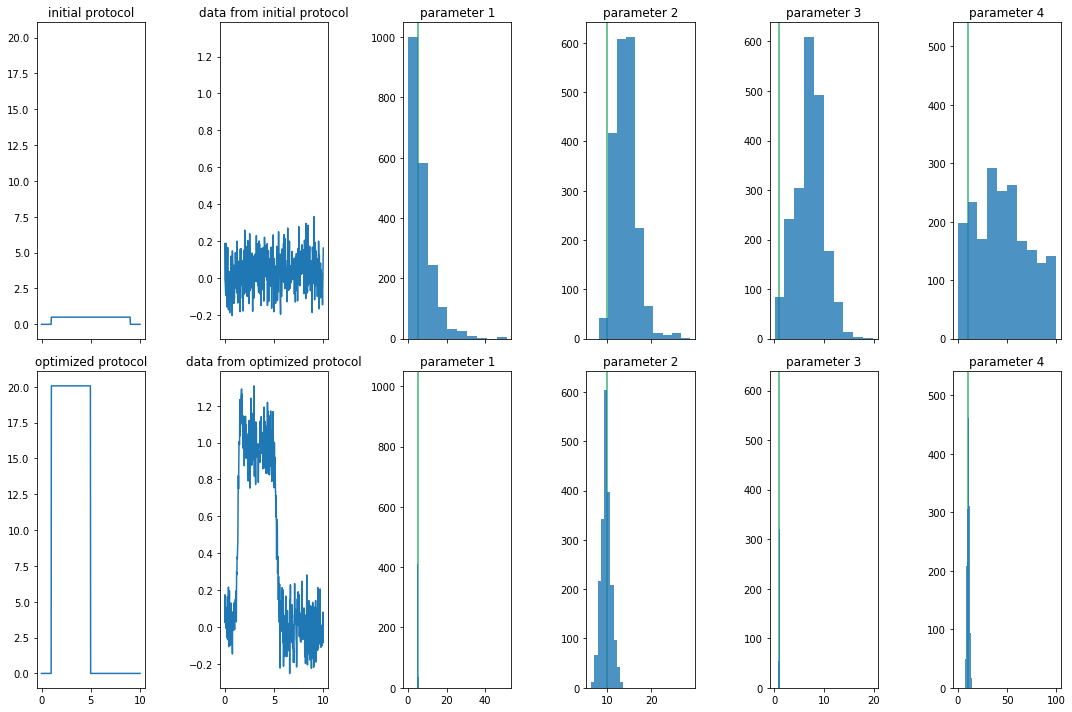

In [8]:
fig = opt.plot(show=False)
fig.set_size_inches(15, 10, forward=True)